# Estimating $g$-factors for CaOH

In [294]:
using Revise

In [295]:
using
    QuantumStates,
    UnitsToValue

### Load $\tilde{X}(01^10)$ Hamiltonian

In [ ]:
H0 = load_from_file("CaOH_BendingMode_Hamiltonian", "..//..//Hamiltonians//")
;

In [ ]:
import QuantumStates: polarizability, Stark, Zeeman

# Add polarizability terms
w = 25e-6; P = 13.25; I_trap = 2P / (π * w^2);
const α = [3.37471e-39, 0, -1.01809e-39] # 1064 nm
const θ_trap = 0 * (π / 2)
const ϵ_trap = cos(θ_trap) * [0.0, 1.0, 0.0] + sin(θ_trap) * [1.0, 0.0, -1.0] / √2
polarizability(state, state′) = polarizability(state, state′, α, ϵ_trap)
H = add_to_H(H0, :I_trap, (1e-6 / h) * polarizability)
H.parameters.I_trap = (1.0 / 3.5) * I_trap / (2ε_0 * c)

# Add Stark terms
μ_X = 1e-6 * 1.465 * (1e-21 / c) / h
H = add_to_H(H, :E, 1e2 * μ_X * Stark) # 1e2 converts from V/m to V/cm
H.parameters.E = 10.0

# Add Zeeman terms
const _μB = (μ_B / h) * (1e-6 * 1e-4)
Zeeman_x(state, state′) = (1/√2)  * (Zeeman(state, state′, -1) - Zeeman(state, state′, +1))
Zeeman_y(state, state′) = (im/√2) * (Zeeman(state, state′, -1) + Zeeman(state, state′, +1))
Zeeman_z(state, state′) = Zeeman(state, state′, 0)
H = add_to_H(H, :B_x, gS * _μB * Zeeman_x)
H = add_to_H(H, :B_y, gS * _μB * Zeeman_y)
H = add_to_H(H, :B_z, gS * _μB * Zeeman_z)
H.parameters.B_x = 0.0
H.parameters.B_y = 0.0
H.parameters.B_z = 1e-6

TDM_magnetic_x(state, state′) = (1/√2)  * (TDM_magnetic(state, state′, -1) - TDM_magnetic(state, state′, +1))
TDM_magnetic_y(state, state′) = (im/√2) * (TDM_magnetic(state, state′, -1) + TDM_magnetic(state, state′, +1))
TDM_magnetic_z(state, state′) = TDM_magnetic(state, state′, 0)

@time full_evaluate!(H)
@time QuantumStates.solve!(H)
;

  0.211705 seconds (162.29 k allocations: 11.372 MiB, 48.46% compilation time: 100% of which was recompilation)
  0.078351 seconds (624 allocations: 949.547 KiB)


  5.905249 seconds (158.13 k allocations: 104.484 MiB, 0.22% gc time, 1.48% compilation time)


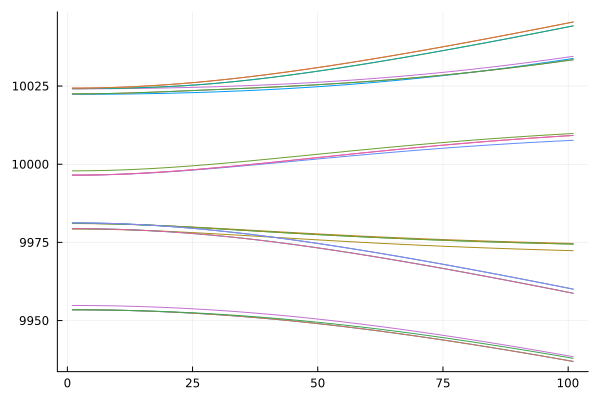

In [ ]:
E_scan_range = 0:1:100
@time x = scan_single_parameter(deepcopy(H), :E, E_scan_range, H -> energy.(H.states))
plot(x[:,1:24], legend=nothing)

In [ ]:
function g_factor(H)
    ΔB = 1e-6
    
    evaluate!(H)
    solve!(H)
    bare_energies = energy.(H.states)
    
    H.parameters.B_z += ΔB
    evaluate!(H)
    solve!(H)
    B_energies = energy.(H.states)

    # `H` needs to be "reset" for the next calculation
    H.parameters.B_z -= ΔB
    
    return (B_energies .- bare_energies) ./ ΔB
end

g_factor (generic function with 1 method)

In [ ]:
E_scan_range = 0:0.5:100
@time x = scan_single_parameter(deepcopy(H), :E, E_scan_range, g_factor)
;

 41.953617 seconds (467.68 k allocations: 570.472 MiB, 0.12% gc time, 0.26% compilation time)


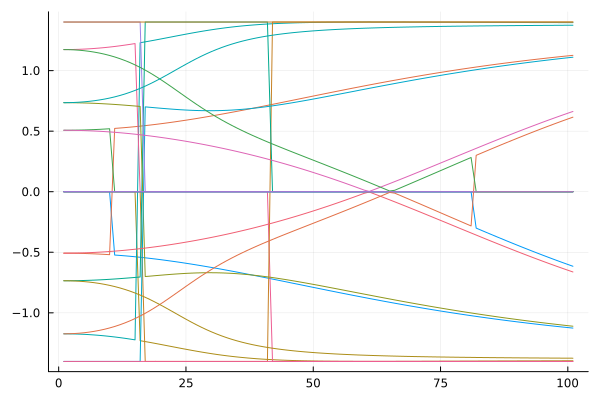

In [ ]:
plot(x[:,1:24], legend=nothing)